##Bring in libraries and dataframes and set indexes

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#Read in existingdata
ExistingData = pd.read_pickle('.\DataFrames\Data.pkl')

#read in the fresh data
StartRead = ExistingData.index.size + 4
Skips = [0,2,3] + list(range(4,StartRead))

FreshData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersCS650.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = Skips, #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

#Read in calibration coefficients calculated in C:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.ipynb
SensorCoefficients = pd.read_pickle('D:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.pkl')

#Bring in all index data
AllDataIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\IndexFiles\StonyLysimetersWater&TempIndex.csv',
                         index_col = 0)

#Bring in index for horizion types
HorizonIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\IndexFiles\HorizonIndex.csv', #specify file path for data to read in
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

#Apply indexes to data
FreshDataTransposed = FreshData.transpose()
FreshDataIndexed = pd.concat([AllDataIndex,FreshDataTransposed], axis=1)
FreshDataIndexed.index.name='ColumnHeader'
FreshDataIndexed.set_index(['Measurement','Depth','Gravels','Stones','Column','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                        append=False, inplace=True)
FreshDataIndexed.sort(inplace=True)
Data= ExistingData.append(FreshDataIndexed.transpose())
Data.index = Data.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:33: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [12]:
max(Data.index)

Timestamp('2017-10-31 10:15:00')

In [14]:
SensorCoefficients

,Slope,Intercept,LL,DUL,SWC25
Horizon,,,,,
Gravel,0.638859,-0.012200,0.004688,0.120,0.147515
SubSoil_0,0.971923,0.035146,0.092807,0.320,0.278127
TopSoil_0,0.950379,0.131111,0.172804,0.350,0.368705
TopSoil_30,0.886315,0.030407,0.139319,0.245,0.251986
TopSoil_50,0.487783,0.024764,0.078916,0.175,0.146709
SubSoil_30,0.750000,0.000000,0.064965,0.224,0.187500
SubSoil_50,0.550000,0.000000,0.046403,0.160,0.137500


## Create new data frame and apply calibration coefficients for each horizon type

In [15]:
StartDate = '2017-01-01'

In [16]:
VWC_uncalibrated = Data.VolumetricWaterContent.ix[StartDate:]
VWC_uncalibrated.columns = VWC_uncalibrated.columns.swaplevel('Depth','Sensor') #Make sensor the top level so index selection works properly
VWC_calibrated = pd.DataFrame(index = VWC_uncalibrated.index, columns = VWC_uncalibrated.columns)  #Set up empty dataframe with the same index and column structure as TDR data

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    Slope = SensorCoefficients.ix[Horizon,'Slope']
    Intercept = SensorCoefficients.ix[Horizon,'Intercept']
    VWC_calibrated[SensorRef] = VWC_uncalibrated.ix[:,SensorRef] * Slope + Intercept 

## Remove eronius data

(0, 0.5)

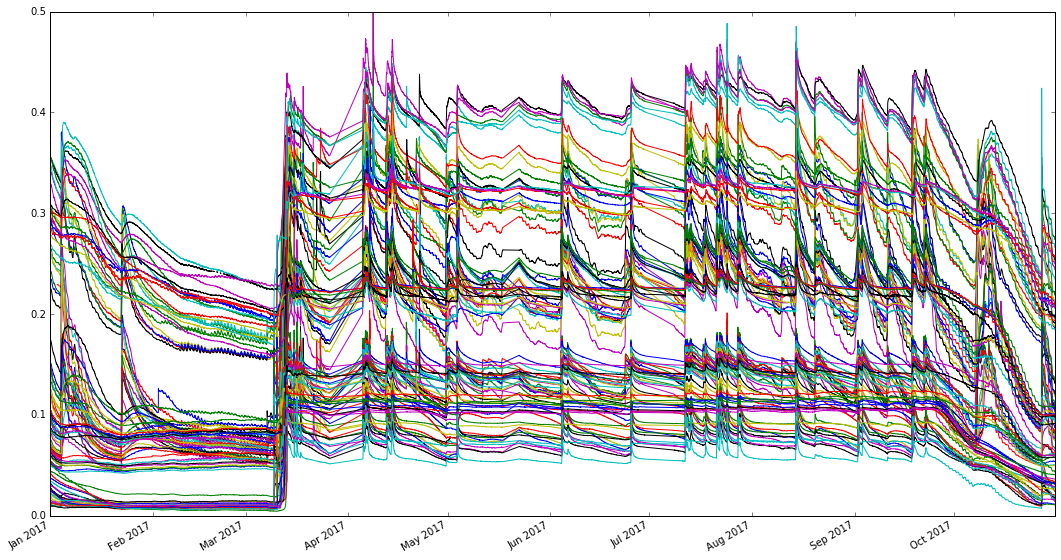

In [18]:
VWC_calibrated.where(VWC_calibrated<0.6,np.nan,inplace=True)
VWC_calibrated.ix['2015-06-18 11:45':'2015-06-21 12:15',:] = np.nan
VWC_calibrated.plot(figsize=(18,10),legend=False)
plt.ylim(0,0.5)

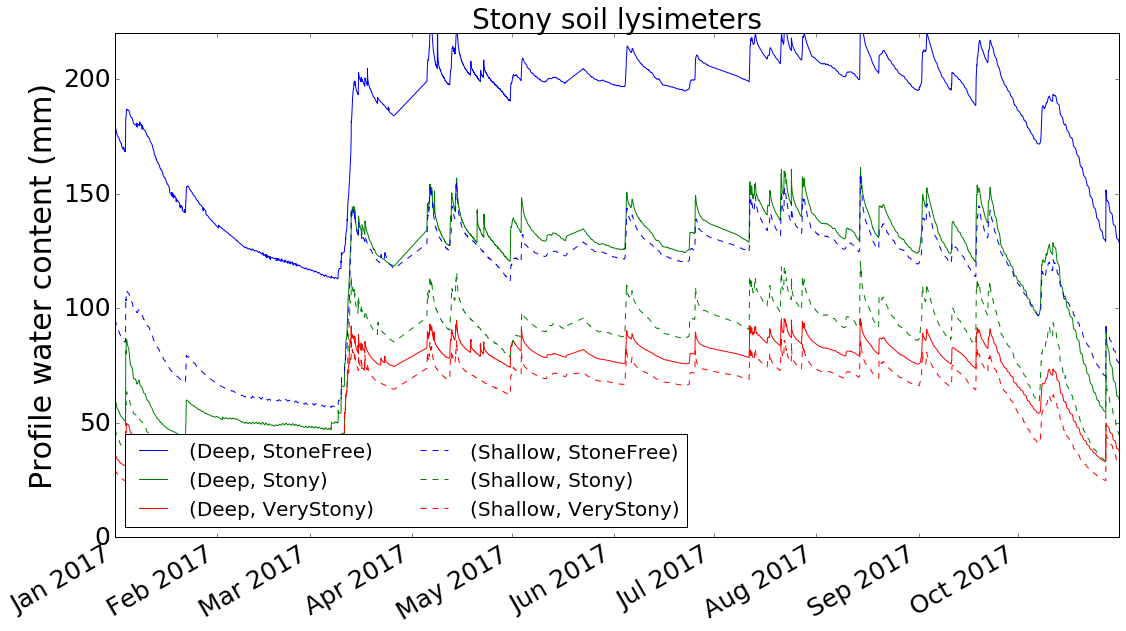

In [23]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
#DataMeans =  Data.ix['2014-11-05 08:00:00':].groupby(level=['Depth','Gravels','Stones'],axis=1).mean()
DataMeans =  VWC_calibrated.ix[StartDate:].groupby(level=['Depth','Gravels','Stones'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
DataMeans.where(DataMeans<0.7,np.nan,inplace=True)

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.ix[:,'D1'] * 150 + \
               DataMeans.ix[:,'D2'] * 150 + \
               DataMeans.ix[:,'D3'] * 150 + \
               DataMeans.ix[:,'D4'] * 150 
                
ProfileWater.plot(figsize=(18,10),style=['b-','g-','r-','b--','g--','r--'],ylim=(0,220))
plt.ylabel('Profile water content (mm)', fontsize=30);
plt.tick_params(labelsize=25)
plt.title('Stony soil lysimeters', fontsize=28)
plt.legend(fontsize = 20, loc=3, ncol=2)